# Testing GLM using Tensorflow

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import os, time
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
def make_cos_bump(n_bump, bin_size=100, b=10, range_until=None):
    if range_until is None:
        range_until = bin_size
        
    bump_range = np.array([0, bin_size * (1 - 1.5 / n_bump)])

    log_func = lambda x: np.log(x + b)
    exp_func = lambda x: np.exp(x) - b

    range_log = log_func(bump_range)
    gap_log = np.diff(range_log) / (n_bump - 1)

    cos_func = lambda x, peak: (np.cos(np.max([-np.pi, 
                                               np.min([np.pi,
                                                       (x - peak) * np.pi / (2 * gap_log)])])) + 1) / 2
    cos_func_vec = np.vectorize(cos_func)

    bin_log = np.tile(log_func(np.arange(range_until))[:, np.newaxis], n_bump)
    peak_log = np.tile(np.arange(range_log[0], range_log[1] + gap_log, gap_log)[:, np.newaxis], range_until).T

    bump = cos_func_vec(bin_log, peak_log)
    bump /= np.sqrt(np.sum(bump**2, 0))
    
    return bump

In [3]:
## main function

# parameter
n_k = 8
n_h = 8
n_ht = 177

# load spike data
data = sio.loadmat('glm_data.mat', squeeze_me=True)
sps = data['sps']
Stim = data['Stim']
dtSp = data['dtSp']

# dimension
n_kt = data['nkt']
n_sps = len(sps)
n_stim = len(Stim)
ratio = int(n_sps / n_stim)

# get sta
sps_coarse = np.sum(sps.reshape((-1, ratio)), 1) # row first (matlab: col first)
spike_time = np.where(sps_coarse > 0)[0]
n_spike = len(spike_time)
stim_aligned = np.zeros((n_spike, n_kt))
for i_spike in range(n_spike):
    if spike_time[i_spike] < n_kt:
        stim_aligned[i_spike, n_kt-spike_time[i_spike]-1:] = Stim[0:spike_time[i_spike]+1]
    else:
        stim_aligned[i_spike, :] = Stim[(spike_time[i_spike]-n_kt+1):(spike_time[i_spike]+1)]
sta = np.flip(np.mean(stim_aligned, 0))


# get cross-correlogram
spike_time = np.where(sps > 0)[0]
n_spike = len(spike_time)
spike_aligned = np.zeros((n_spike, n_ht))
for i_spike in range(n_spike):
    if spike_time[i_spike] > n_sps - n_ht - 1:
        spike_aligned[i_spike, 0:n_sps - spike_time[i_spike] - 1] = sps[spike_time[i_spike]+1:]
    else:
        spike_aligned[i_spike, :] = sps[spike_time[i_spike]+1:spike_time[i_spike]+1+n_ht]
stc = np.log(np.mean(spike_aligned, 0) / np.mean(sps) + np.exp(-10))

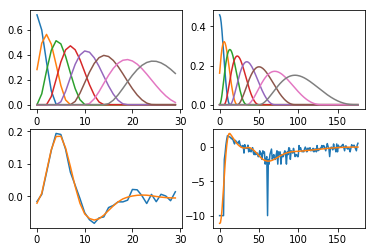

In [4]:
# make bump
k_base = make_cos_bump(n_k, n_kt, 10)
h_base = make_cos_bump(n_h, np.floor(n_ht*2/3), 20, n_ht)

# calc starting weights
w_k0 = np.linalg.pinv(k_base.T @ k_base) @ (k_base.T @ sta)
w_h0 = np.linalg.pinv(h_base.T @ h_base) @ (h_base.T @ stc)

# calc starting kernels
k0 = k_base @ w_k0
h0 = h_base @ w_h0
c0 = np.log(np.mean(sps))

# plot
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(k_base)

ax[1, 0].plot(sta)
ax[1, 0].plot(k0)

ax[0, 1].plot(h_base)
ax[1, 1].plot(stc)
ax[1, 1].plot(h0)

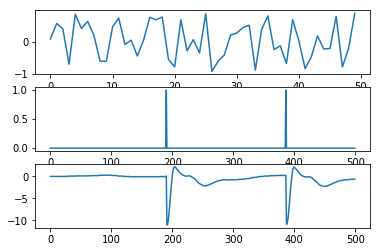

In [5]:
# convolution
k_base_conv = np.zeros((n_sps, n_k))
for i_k in range(n_k):
    k_base_conv_temp = np.convolve(Stim, k_base[:, i_k])
    k_base_conv[:, i_k] = np.kron(k_base_conv_temp[0:-n_kt+1], np.ones((1, ratio)))

h_base_conv = np.zeros((n_sps, n_h))
for i_h in range(n_h):
    h_base_conv_temp = np.convolve(sps, h_base[:, i_h])
    h_base_conv[:, i_h] = np.append(0, h_base_conv_temp[0:-n_ht])
    
# probability
I_k0 = k_base_conv @ w_k0
I_h0 = h_base_conv @ w_h0
I_total0 = I_k0 + I_h0

fig, ax = plt.subplots(3)
ax[0].plot(Stim[:50])
ax[1].plot(sps[:500])
ax[2].plot(I_total0[:500])

In [6]:
# make model
prm0 = np.append(w_k0, w_h0)

X = np.concatenate([k_base_conv, h_base_conv], 1).astype(np.float32)
n_X = X.shape[1]
y = sps.astype(np.float32)

tf.reset_default_graph()
glm = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[n_X],
                      kernel_initializer=keras.initializers.Constant(value=prm0),
                      bias_initializer=keras.initializers.Constant(value=c0))
])

glm.compile(optimizer=tf.train.RMSPropOptimizer(0.001), 
            loss=tf.nn.log_poisson_loss)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6)

t = time.time()
history = glm.fit(X, y, epochs=50, callbacks=[early_stop])
elapsed_time = time.time() - t
print(elapsed_time)

Epoch 1/50
500000/500000 [==============================] - 73s 146us/sample - loss: 0.0298
Epoch 2/50
 35040/500000 [=>............................] - ETA: 1:03 - loss: 0.0333

KeyboardInterrupt: 

-5.318520073865556
-5.318519


(0.025, 0.032)

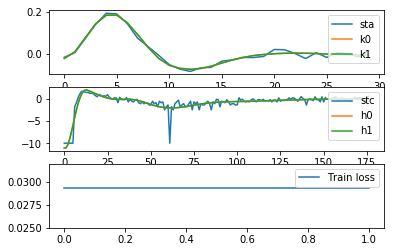

In [35]:
w_k1 = glm.get_weights()[0][0:8]
w_h1 = glm.get_weights()[0][8:]
w_c1 = glm.get_weights()[1][0]
print(c0)
print(w_c1)

# calc starting kernels
k1 = k_base @ w_k1
h1 = h_base @ w_h1

# plot
fig, ax = plt.subplots(3)
ax[0].plot(sta, label='sta')
ax[0].plot(k0, label='k0')
ax[0].plot(k1, label='k1')
ax[0].legend(loc=1)

ax[1].plot(stc, label='stc')
ax[1].plot(h0, label='h0')
ax[1].plot(h1, label='h1')
ax[1].legend(loc=1)

ax[2].plot(history.history["loss"], label='Train loss')
#ax[2].plot(history.history["val_loss"], label='Validation loss')
ax[2].legend(loc=1)
ax[2].set_ylim([0.025, 0.032])

In [15]:
glm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 1)           17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [16]:
glm.get_weights()

[array([[-2.6357163e-02],
        [-8.3457883e-03],
        [ 3.3531412e-01],
        [ 7.7897280e-02],
        [-1.3787316e-01],
        [-9.1008872e-02],
        [ 5.2477166e-02],
        [-2.4727387e-02],
        [-2.2191200e+01],
        [-5.7438588e+00],
        [ 1.5980524e+01],
        [-1.2839910e+01],
        [ 1.2776862e+01],
        [-1.3410624e+01],
        [-9.0028286e-01],
        [-3.7293923e+00]], dtype=float32), array([-5.31852], dtype=float32)]

In [17]:
prm0

array([-2.63571635e-02, -8.34578829e-03,  3.35314137e-01,  7.78972834e-02,
       -1.37873154e-01, -9.10088710e-02,  5.24771676e-02, -2.47273876e-02,
       -2.21912012e+01, -5.74385871e+00,  1.59805240e+01, -1.28399095e+01,
        1.27768622e+01, -1.34106240e+01, -9.00282831e-01, -3.72939232e+00])

In [19]:
X.shape

(500000, 16)

In [20]:
y.shape

(500000,)

9.999999999999999e-05